<a href="https://colab.research.google.com/github/FieldTien/MvtecAD-supervise-learning-Grad-Cam/blob/main/ResNet50_30class%2BGrad_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download the dataset
Dataset is alredy resized into 256x256

The second file is train,valid and test data directory

In [ ]:
!gdown --id 1IC_J1TEwDIhs44rMwm8GkRzzwkH5OlxU
!gdown --id 1XQ3JODnyzti76oKrYIsrfQyrzWPgMB_f
! unzip mvtecad_supervise.zip

In [2]:
import os
import os.path
import pickle
import numpy as np
from pathlib import Path
from PIL import Image
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.optim.lr_scheduler import StepLR
import torchvision.models as models
import time
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix,roc_auc_score
from sklearn.preprocessing import label_binarize

data_path label 0-14 is normal and 15-29 is abnormal
*wood,tile,leather,transistor,hazelnut,toothbrush,capsule,pill,screw,carpet,bottle,grid,cable, zipper, metal_nut*
*   Training set : 2990
*   Validation  set  : 796
*   Testing  set  : 1568

In [3]:
Path = "/content/RES50_30class.pkl"
data_path = "/content/train_val_test_split.txt"
with open(data_path, "rb") as fp:   #Pickling
   data_dir = pickle.load(fp) 
train_images,train_labels= data_dir[0][0], data_dir[0][1] 
valid_images,valid_labels= data_dir[1][0], data_dir[1][1] 
test_images,test_labels= data_dir[2][0], data_dir[2][1]   
print(train_images[:5],train_labels[:5])
print(valid_images[:5],valid_labels[:5])
print(test_images[:5],test_labels[:5]) 
print(len(train_images))
print(len(valid_images))
print(len(test_images))

['mvtecad_supervise/wood/train/good/022.png', 'mvtecad_supervise/wood/train/good/043.png', 'mvtecad_supervise/wood/train/good/038.png', 'mvtecad_supervise/wood/test/good/018.png', 'mvtecad_supervise/wood/train/good/163.png'] [0, 0, 0, 0, 0]
['mvtecad_supervise/wood/train/good/013.png', 'mvtecad_supervise/wood/train/good/193.png', 'mvtecad_supervise/wood/train/good/178.png', 'mvtecad_supervise/wood/train/good/088.png', 'mvtecad_supervise/wood/train/good/223.png'] [0, 0, 0, 0, 0]
['mvtecad_supervise/wood/train/good/221.png', 'mvtecad_supervise/wood/train/good/168.png', 'mvtecad_supervise/wood/train/good/056.png', 'mvtecad_supervise/wood/train/good/173.png', 'mvtecad_supervise/wood/train/good/063.png'] [0, 0, 0, 0, 0]
2990
796
1568


In [4]:
def default_loader(path):
    return Image.open(path).convert('RGB')
class myImageFloder(data.Dataset):
    def __init__(self, images, labels, training, loader=default_loader):
        self.images = images
        self.labels = labels
        self.loader = loader
        self.training = training
    def __getitem__(self, index):
        images = self.images[index]
        labels_id = self.labels[index]
        images = self.loader(images)
        labels = labels_id    
        if(self.training==True):
          t_list = [     
            transforms.Resize(size=224),
            transforms.RandomRotation(degrees=300),
            transforms.RandomHorizontalFlip(),
            #transforms.CenterCrop(size=224),  # Image net standards
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                      [0.229, 0.224, 0.225]) ] 
        else :
            t_list = [transforms.Resize(size=224),
                  transforms.ToTensor(),
                  transforms.Normalize([0.485, 0.456, 0.406], 
                            [0.229, 0.224, 0.225])]         
        processed = transforms.Compose(t_list)
        images = processed(images)
        return images, labels
    def __len__(self):
        return len(self.images)

The labels of weights into loss function 14-29 is larger since the normal data and abnornal data ratio is imbalance

In [5]:
class_count=np.array([train_labels.count(i) for i in range(30)])
class_sum = np.sum(class_count)
weight = class_sum/(30*class_count)
weight = weight/np.sum(weight)
loss_weight = weight*20
print("The weight of each class : ",loss_weight)

The weight of each class :  [0.28407796 0.28799628 0.27293765 0.27655272 0.17545992 1.04398651
 0.31163776 0.25777445 0.20984653 0.24564388 0.33142429 0.26598382
 0.26768885 0.2783964  0.31163776 1.15998501 0.86998876 0.78791435
 1.73997751 1.04398651 2.45643884 0.67353968 0.51554889 0.61410971
 0.80306654 1.15998501 1.19312744 0.75926291 0.61410971 0.78791435]


###Define the anomaly detection model
Here we use the imageNet pretrained ResNet50 model and unfreeze all the residual block

In [6]:
device = torch.device('cuda')
import torchvision.models as models
model=models.resnet50(pretrained=True)

class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()     
        self.features_conv = nn.Sequential(*[model.conv1,model.bn1,model.relu,model.maxpool,model.layer1])    
        self.Conv2d_0 = nn.Sequential(*[model.layer2,model.layer3,model.layer4,model.avgpool])
        self.classifier = nn.Sequential(nn.Linear(2048,512),nn.BatchNorm1d(512),nn.ReLU(True),nn.Dropout(0.2),nn.Linear(512,30))       
        for param in self.features_conv.parameters():
          param.requires_grad = True
        for param in self.Conv2d_0.parameters():   
            param.requires_grad = True     
        for param in self.classifier.parameters():   
            param.requires_grad = True  
        
    def forward(self, x,val=True):
        x = self.features_conv(x) 
        x = self.Conv2d_0(x)       
        x = x.view((-1, 2048))
        x = self.classifier(x)
        return x 
model=ResNet50().to(device)         

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

###Define the evaluation, train, validation function
In sklearn_evaluate, transform the predictions and labels 0-14,15-29 into 0,1 and calculate the binary evaluate score

In [7]:
def sklearn_evaluate(y_true, y_pred, evalaute = True):
  y_pred_logit = y_pred
  _, y_pred = torch.max(y_pred.data, 1)
  predict = y_pred.to('cpu').detach().numpy()
  truth_all = y_true.to('cpu').numpy().astype(int)  
  f1 = f1_score(truth_all, predict, average='weighted')*100
  acc = accuracy_score(truth_all, predict)*100
  truth_all_binary = label_binarize(truth_all, classes=list(range(30)))
  if evalaute:
    correct_binary = torch.where(y_true>=15,1,0) 
    predicted_binary = torch.where(y_pred>=15,1,0) 
    predicted_binary = predicted_binary.to('cpu').detach().numpy()
    correct_binary = correct_binary.to('cpu').numpy().astype(int)  
    binary_f1 = f1_score(correct_binary, predicted_binary)*100
    binary_acc = accuracy_score(correct_binary, predicted_binary)*100 
    binary_conf = confusion_matrix(correct_binary, predicted_binary)
    confusion = confusion_matrix(truth_all, predict)
    Softmax=torch.nn.Softmax(dim=1)
    y_score = Softmax(y_pred_logit).to('cpu').detach().numpy()
    binary_score=np.sum(y_score[:,15:30],axis=1)
    auc_score = roc_auc_score(correct_binary, binary_score)*100

    return (acc, f1, confusion, auc_score,binary_acc,binary_f1,binary_conf)
  else:
    return (acc, f1) 
def train(model, optimizer,loss_weight,trainloader):
  model.train()
  epoch_loss ,epoch_acc,epoch_f_score = 0 , 0 , 0
  for batch, labels in trainloader:
      batch = batch.to(device)
      labels = labels.to(device)
      weights=torch.tensor(loss_weight).float()
      criterion = nn.CrossEntropyLoss(weight=weights).to(device)
      optimizer.zero_grad()
      predict = model(batch)
      loss = criterion(predict, labels)
      loss.backward()
      optimizer.step()
      acc, f1 = sklearn_evaluate(labels, predict, evalaute = False)
      epoch_loss  += loss.item()
      epoch_acc += acc
      epoch_f_score += f1       
  return (epoch_loss/len(trainloader) ,epoch_acc/len(trainloader) ,epoch_f_score/len(trainloader) )   
def validate(model, loader):
  model.eval()
  epoch_loss = 0
  criterion = nn.CrossEntropyLoss().to(device)
  predict = torch.zeros([0]).to(device)
  correct = torch.zeros([0]).to(device)
  with torch.no_grad():
      for batch, labels in loader:
          batch = batch.to(device)
          labels = labels.to(device)
          predicted = model(batch)
          predict = torch.cat([predict,predicted],0) 
          correct = torch.cat([correct,labels],0).type(labels.dtype)          
      loss = criterion(predict, correct)
      epoch_loss = loss.item()    
      acc, f1, confusion, auc_score,binary_acc,binary_f1,binary_conf = sklearn_evaluate(correct, predict, evalaute = True)       
  return (epoch_loss, acc , f1 , confusion, auc_score,binary_f1,binary_acc,binary_conf)

### Train the model with 200 epochs
Save the model if auc and fscore in validation is  better than before

In [8]:
EPOCH = 200
BATCH_SIZE =128
params = 0
for param in model.parameters():
  if param.requires_grad:
    params += param.numel()
print('Number of Weight %d' %(params))   
trainloader = torch.utils.data.DataLoader(
    myImageFloder(train_images, train_labels, True), 
    batch_size= BATCH_SIZE, shuffle= True
        , num_workers= 0, drop_last=False
)
valloader = torch.utils.data.DataLoader(
    myImageFloder(valid_images, valid_labels, False), 
    batch_size= BATCH_SIZE, shuffle= False
        , num_workers= 0, drop_last=False
)
testloader = torch.utils.data.DataLoader(
    myImageFloder(test_images, test_labels, False), 
    batch_size= BATCH_SIZE, shuffle= False
        , num_workers= 0, drop_last=False
) 
#optimizer = optim.SGD(model.parameters(), lr=0.005,momentum = 0.7)

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)
start = time.time()
t_acc,t_loss,t_fscore ,v_acc,v_loss , v_fscore, v_auc = [],[],[],[],[],[],[]
best_f, best_epoch = 0, 0 

for epoch in range(EPOCH):  # loop over the dataset multiple times
  print('\n============================\nEpoch: ', epoch)

  train_loss,train_acc,train_fscore=train(model, optimizer,loss_weight,trainloader)

  t_acc += [train_acc]
  t_loss += [train_loss]
  t_fscore += [train_fscore]

  print('Train loss:  {:.4f}'.format(train_loss ))
  print('Train Accuracy : {:.4f}%'.format(train_acc))  
  print('Train f score : {:.4f}%'.format(train_fscore))   
  valid_loss, valid_accuracy, fscore, conf, auc,binary_f1,binary_acc,binary_conf = validate(model,valloader)
  print("#"*15," Valid ", "#"*15)
  #print("#"*15,"Best Epoch ", best_epoch, "#"*15)
  print('\nValid loss:  {:.4f}'.format(valid_loss))
  print('Valid Accuracy: {:.4f}%'.format(valid_accuracy)) 
  print('Valid F score: {:.4f}%'.format(fscore))  
  print('Binary Accuracy: {:.4f}%'.format(binary_acc)) 
  print('Binary F score: {:.4f}%'.format(binary_f1)) 
  print('Valid Binary confusion matrix : \n', binary_conf)  
  #print('Valid confusion matrix : \n', conf)
  print('Valid AUC score: {:.4f}%'.format(auc))  
  if (auc > best_f):
    torch.save(model.state_dict(), Path)
    best_f = auc
    best_epoch = epoch+1
  scheduler.step()   
print('\n============================\nTraining :%.4f\n'%(time.time() - start))

Number of Weight 24573534

Epoch:  0
Train loss:  1.4109
Train Accuracy : 57.2280%
Train f score : 55.0477%
###############  Valid  ###############

Valid loss:  0.9579
Valid Accuracy: 67.5879%
Valid F score: 62.0238%
Binary Accuracy: 67.5879%
Binary F score: 38.8626%
Valid Binary confusion matrix : 
 [[456 158]
 [100  82]]
Valid AUC score: 65.0696%

Epoch:  1
Train loss:  0.7492
Train Accuracy : 67.6305%
Train f score : 65.3189%
###############  Valid  ###############

Valid loss:  0.6366
Valid Accuracy: 72.1106%
Valid F score: 69.2145%
Binary Accuracy: 72.1106%
Binary F score: 49.0826%
Valid Binary confusion matrix : 
 [[467 147]
 [ 75 107]]
Valid AUC score: 79.8538%

Epoch:  2
Train loss:  0.5734
Train Accuracy : 75.4543%
Train f score : 75.0573%
###############  Valid  ###############

Valid loss:  0.6102
Valid Accuracy: 72.1106%
Valid F score: 66.5111%
Binary Accuracy: 72.1106%
Binary F score: 53.5565%
Valid Binary confusion matrix : 
 [[446 168]
 [ 54 128]]
Valid AUC score: 83.59

#### The result of best model  in validation set and testing set

In [9]:
model.load_state_dict(torch.load(Path, map_location=device))

valid_loss, valid_accuracy, fscore, conf, auc,binary_f1,binary_acc,binary_conf = validate(model,valloader)
print('\nValid loss:  {:.4f}'.format(valid_loss))
print('Valid Accuracy: {:.4f}%'.format(valid_accuracy)) 
print('Valid F score: {:.4f}%'.format(fscore))  
print('Binary Accuracy: {:.4f}%'.format(binary_acc)) 
print('Binary F score: {:.4f}%'.format(binary_f1)) 
print('Valid Binary confusion matrix : \n', binary_conf)  
print('Valid AUC score: {:.4f}%'.format(auc))   

print("\n")
print("#"*15," Test ", "#"*15)

test_loss,test_accuracy,t_fsocre, conf, auc,binary_f1,binary_acc,binary_conf = validate(model,testloader)
print('\nTest loss:  {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}%'.format(test_accuracy)) 
print('Test F score: {:.4f}%'.format(t_fsocre))  
print('Binary Accuracy: {:.4f}%'.format(binary_acc)) 
print('Binary F score: {:.4f}%'.format(binary_f1)) 
print('Test Binary confusion matrix : \n', binary_conf)  
print('Test AUC score: {:.4f}%'.format(auc)) 


Valid loss:  0.0860
Valid Accuracy: 98.1156%
Valid F score: 98.1142%
Binary Accuracy: 98.1156%
Binary F score: 95.8449%
Valid Binary confusion matrix : 
 [[608   6]
 [  9 173]]
Valid AUC score: 99.5606%


###############  Test  ###############

Test loss:  0.0978
Test Accuracy: 97.5128%
Test F score: 97.4860%
Binary Accuracy: 97.5128%
Binary F score: 94.2731%
Test Binary confusion matrix : 
 [[1208   12]
 [  27  321]]
Test AUC score: 99.2677%


In [10]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
def confususion_matrix(conf):
  class_indices = ['wood_good', 'tile_good', 'leather_good', 'transistor_good', 'hazelnut_good', 'toothbrush_good', 'capsule_good', 'pill_good', 'screw_good', 'carpet_good', 'bottle_good', 'grid_good', 'cable_good', 'zipper_good', 'metal_nut_good', 'wood_bad', 'tile_bad', 'leather_bad', 'transistor_bad', 'hazelnut_bad', 'toothbrush_bad', 'capsule_bad', 'pill_bad', 'screw_bad', 'carpet_bad', 'bottle_bad', 'grid_bad', 'cable_bad', 'zipper_bad', 'metal_nut_bad']
  plt_cm = pd.DataFrame(conf, index=class_indices, columns=class_indices)
  plt_cm.index.name = 'Actual'
  plt_cm.columns.name = 'Predicted'
  plt.figure(figsize = (21,15))
  sn.set(font_scale=1.4)
  sn.heatmap(plt_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt="d")
  plt.show()
  conf_normalized = conf.astype('float') / conf.sum(axis=1)[:, np.newaxis]
  plt_cm = pd.DataFrame(conf_normalized, index=class_indices, columns=class_indices)
  plt_cm.index.name = 'Actual'
  plt_cm.columns.name = 'Predicted'
  plt.figure(figsize = (21,15))
  sn.set(font_scale=1.4)
  sn.heatmap(plt_cm, cmap="Blues", annot=True,annot_kws={"size": 16})
  plt.show()

### Confususion matrix in testing set
Due to the 30 classes classification, it's possible  of true label is bottle_good and prediction is pill_good (other class). But we can see the model didn't make the mistakes like this. 


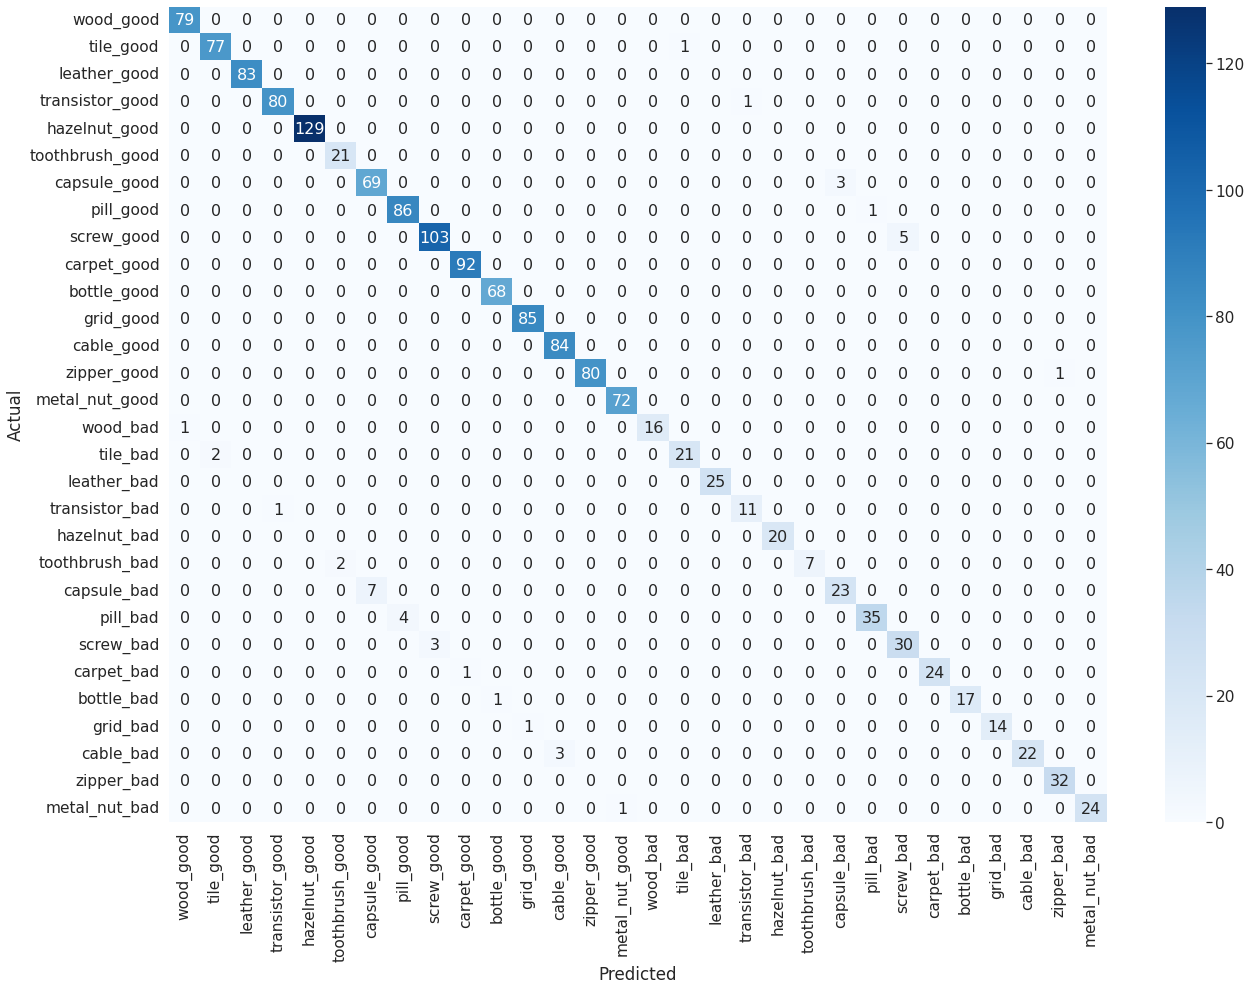

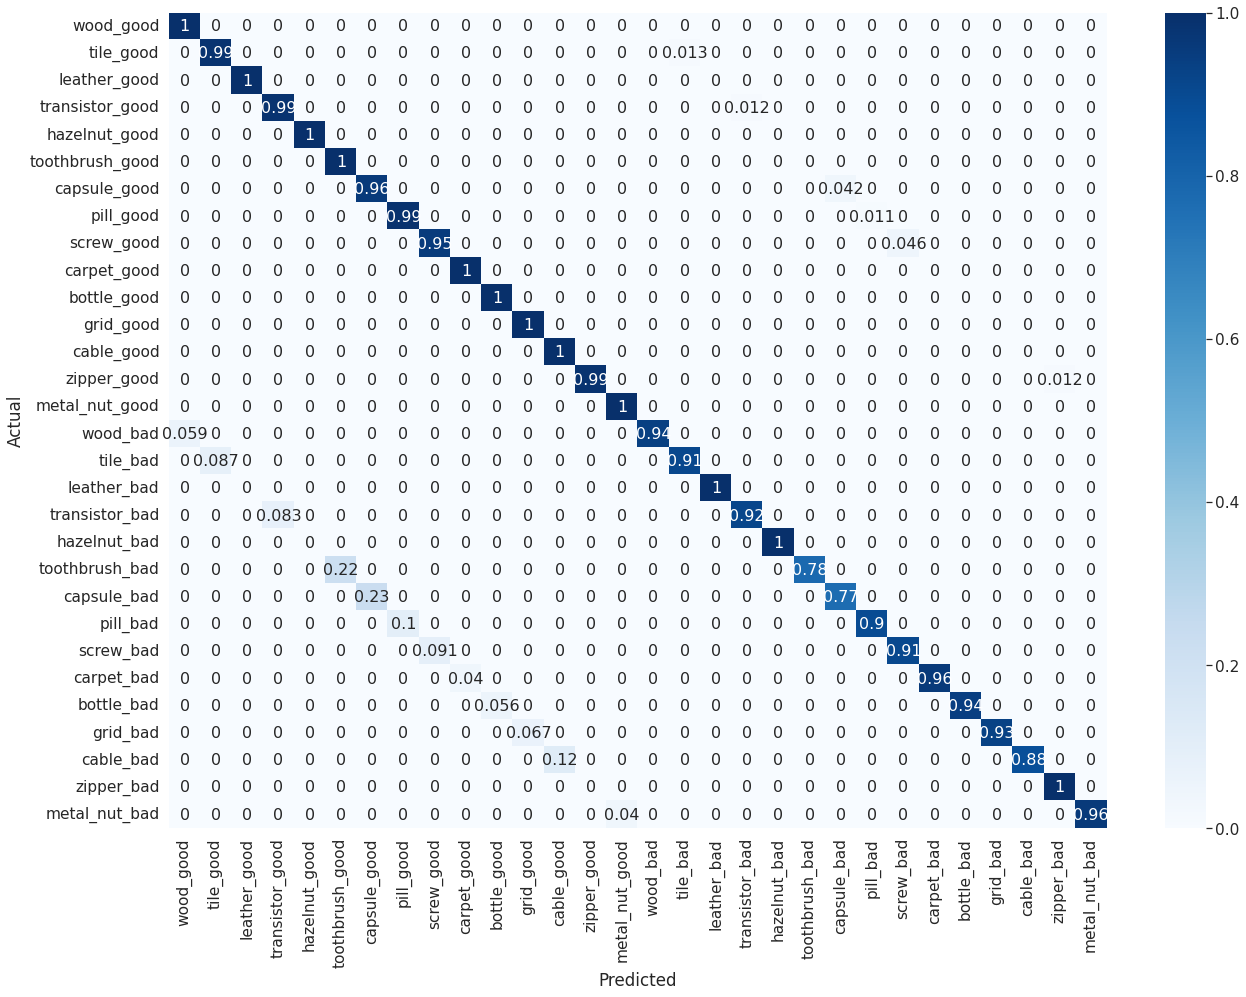

In [11]:
confususion_matrix(conf)

In [12]:
from google.colab import files
files.download(Path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Define the Grad-Cam and Grad-Cam++

In [13]:
def grad_cam(model,img):
  model.eval()
  def normalize(x):
    return (x + 1e-10) / (torch.sqrt(torch.mean(torch.square(x))) + 1e-10)
  img=img.to(device)
  # get the most likely prediction of the model
  pred = model(img,val=False)
  arg_max = pred.argmax(dim=1)
  pred[:, int(arg_max)].backward()
  gradients = model.get_activations_gradient()
  gradients = normalize(gradients)
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
  activations = model.get_activations(img).detach()
  for i in range(activations.shape[1]):
      activations[:, i, :, :] *= pooled_gradients[i]
  heatmap = torch.mean(activations, dim=1).squeeze()
  heatmap = torch.max(heatmap,torch.Tensor([0]))
  # normalize the heatmap
  heatmap /= torch.max(heatmap) 
  heatmap =  heatmap.squeeze()
  return heatmap.detach().to('cpu').numpy(),int(arg_max)

In [14]:
def grad_cam_plus(model,img):
  model.eval()
  def normalize(x):
    return (x + 1e-10) / (torch.sqrt(torch.mean(torch.square(x))) + 1e-10)
  img=img.to(device)
  # get the most likely prediction of the model
  pred = model(img,val=False)
  arg_max = pred.argmax(dim=1)
  y_c = pred[:, int(arg_max)]
  pred[:, int(arg_max)].backward()
  gradients = model.get_activations_gradient()
  gradients = normalize(gradients)
  first = torch.exp(y_c)*gradients
  second = torch.exp(y_c)*gradients*gradients
  third = torch.exp(y_c)*gradients*gradients*gradients
  activations = model.get_activations(img).detach()
  global_sum = torch.sum(activations, dim=[0, 2, 3])
  global_sum = global_sum.reshape(global_sum.shape[0],1,1)
  alpha_num = first[0]
  alpha_denom = second[0]*2.0+third[0]*global_sum
  alphas = alpha_num/alpha_denom 
  weights = torch.max(gradients[0],torch.Tensor([0]))
  alpha_normalization_constant  = torch.sum(alphas, dim=[1, 2])
  alpha_normalization_constant = alpha_normalization_constant.reshape(alpha_normalization_constant.shape[0],1,1)
  alphas /= alpha_normalization_constant
  deep_linearization_weights = weights*alphas
  deep_linearization_weights = torch.sum(deep_linearization_weights, dim=[1, 2])
  deep_linearization_weights = deep_linearization_weights.reshape(deep_linearization_weights.shape[0],1,1)
  grad_CAM_map = torch.sum(deep_linearization_weights*activations[0],axis=0)
  heatmap = torch.max(grad_CAM_map,torch.Tensor([0]))
  # normalize the heatmap
  heatmap /= torch.max(heatmap) 
  return heatmap.detach().to('cpu').numpy(),int(arg_max)

In [15]:
def split_each_class(test_images,test_labels):
  class_img,class_label,class_index = [[] for i in range(15)],[[] for i in range(15)],[[] for i in range(15)]
  for c in range(15):
    class_index[c] = [i for i,j in enumerate(test_labels) if j==c or j==c+15]
    class_img[c] += [test_images[i] for i in class_index[c]]
    class_label[c] += [test_labels[i] for i in class_index[c]]
    class_label[c] = [int(0) if i<15 else int(1) for i in class_label[c]]
  return (class_img,class_label)
valid_class_img,valid_class_label=split_each_class(valid_images,valid_labels)
test_class_img,test_class_label=split_each_class(test_images,test_labels)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_grad(vgg1,grad_cam,model_name='VGG16'):
  invTrans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],std = [ 1., 1., 1. ])])
  predicts_30_class,heatmaps_30_class,img_origin = [],[],[]
  defects,defects_label = [],[int(1)]*15
  for i in range(15):
    defects_index = [index for index,i in  enumerate(valid_class_label[i]) if i==1]
    defects+= [valid_class_img[i][defects_index[0]]]
  goods_class,goods_class_label = [],[int(0)]*15
  for i in range(15):
    good_index = [index for index,i in  enumerate(valid_class_label[i]) if i==0]
    goods_class+= [valid_class_img[i][good_index[0]]]

  valloader = torch.utils.data.DataLoader(
      myImageFloder(defects, defects_label, False), 
      batch_size= 1, shuffle= False
          , num_workers= 0, drop_last=False
  )
  for img,_ in valloader:
    heatmap,predict = grad_cam(vgg1,img)
    predicts_30_class+=[predict]
    heatmaps_30_class+=[heatmap]
    img = invTrans(img)
    img_origin+=[img.squeeze().permute(1,2,0)]
  predicts_30_class_correct,heatmaps_30_class_correct,img_origin_correct = [],[],[]
  valloader = torch.utils.data.DataLoader(
      myImageFloder(goods_class, goods_class_label, False), 
      batch_size= 1, shuffle= False
          , num_workers= 0, drop_last=False
  )
  for img,_ in valloader:
    heatmap,predict = grad_cam(vgg1,img)
    predicts_30_class_correct+=[predict]
    heatmaps_30_class_correct+=[heatmap]
    img = invTrans(img)
    img_origin_correct+=[img.squeeze().permute(1,2,0)]

  defects,defects_label = [],[int(1)]*15
  for i in range(15):
    defects_index = [index for index,i in  enumerate(valid_class_label[i]) if i==1]
    defects+= [valid_class_img[i][defects_index[1]]]
  goods_class,goods_class_label = [],[int(0)]*15
  for i in range(15):
    good_index = [index for index,i in  enumerate(valid_class_label[i]) if i==0]
    goods_class+= [valid_class_img[i][good_index[1]]]

  valloader = torch.utils.data.DataLoader(
      myImageFloder(defects, defects_label, False), 
      batch_size= 1, shuffle= False
          , num_workers= 0, drop_last=False
  )
  predicts_30_class_2,heatmaps_30_class_2,img_origin_2 = [],[],[]
  for img,_ in valloader:
    heatmap,predict = grad_cam(vgg1,img)
    predicts_30_class_2+=[predict]
    heatmaps_30_class_2+=[heatmap]
    img = invTrans(img)
    img_origin_2+=[img.squeeze().permute(1,2,0)]
  fig = plt.figure(figsize = (30, 12))
  cbar_ax = fig.add_axes([.91, .12, .01, .75])
  for i in range(1,16):
    ax = fig.add_subplot(6, 15, i)
    ax.imshow(img_origin[i-1])
    if(i==1): ax.set_ylabel('Defects')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(6, 15, i+15)
    g3 = sns.heatmap(heatmaps_30_class[i-1],yticklabels=False,xticklabels=False,cbar=i == 1,cmap='viridis',ax=ax,cbar_ax=None if(i!=1) else cbar_ax)
    ax.title.set_text('Predict:%s'%predicts_30_class[i-1])
    if(i==1): ax.set_ylabel(model_name)
    ax = fig.add_subplot(6, 15, i+30)
    ax.imshow(img_origin_2[i-1])
    if(i==1): ax.set_ylabel('Defects')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(6, 15, i+45)
    g3 = sns.heatmap(heatmaps_30_class_2[i-1],yticklabels=False,xticklabels=False,cbar=False,cmap='viridis',ax=ax)
    ax.title.set_text('Predict:%s'%predicts_30_class_2[i-1])
    if(i==1): ax.set_ylabel(model_name)
    ax = fig.add_subplot(6, 15, i+60)
    ax.imshow(img_origin_correct[i-1])
    if(i==1): ax.set_ylabel('Good')
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(6, 15, i+75)
    g3 = sns.heatmap(heatmaps_30_class_correct[i-1],yticklabels=False,xticklabels=False,cbar=False,cmap='viridis')
    ax.title.set_text('Predict:%s'%predicts_30_class_correct[i-1])
    if(i==1): ax.set_ylabel(model_name)

###Take the gradient of last residual block's feature map on outputs
Since the last residual block's feature map size is 7x7, then the Grad-Cam result is 7x7

In [17]:
class RES(nn.Module):
    def __init__(self,model):
        super(RES, self).__init__()     
        self.res = model
        self.features_conv = self.res.features_conv 
        self.Conv_0  = self.res.Conv2d_0[:3] 
        self.Conv_1  = self.res.Conv2d_0[3:]      
        self.classifier = self.res.classifier       
        self.gradients = None  
    def activations_hook(self, grad):
        self.gradients = grad       
    def forward(self, x,val=True):
        x = self.features_conv(x)    
        
        x = self.Conv_0(x) 
        
        if(val==False):  
          h = x.register_hook(self.activations_hook) 
        x = self.Conv_1(x)          
        x = x.view((-1, 2048))
        x = self.classifier(x)
        return x   
    def get_activations_gradient(self):
        return self.gradients
    def get_activations(self, x):
       x = self.features_conv(x)    
       x = self.Conv_0(x) 
       return x
device = "cpu"       
res1 = RES(model).to(device)

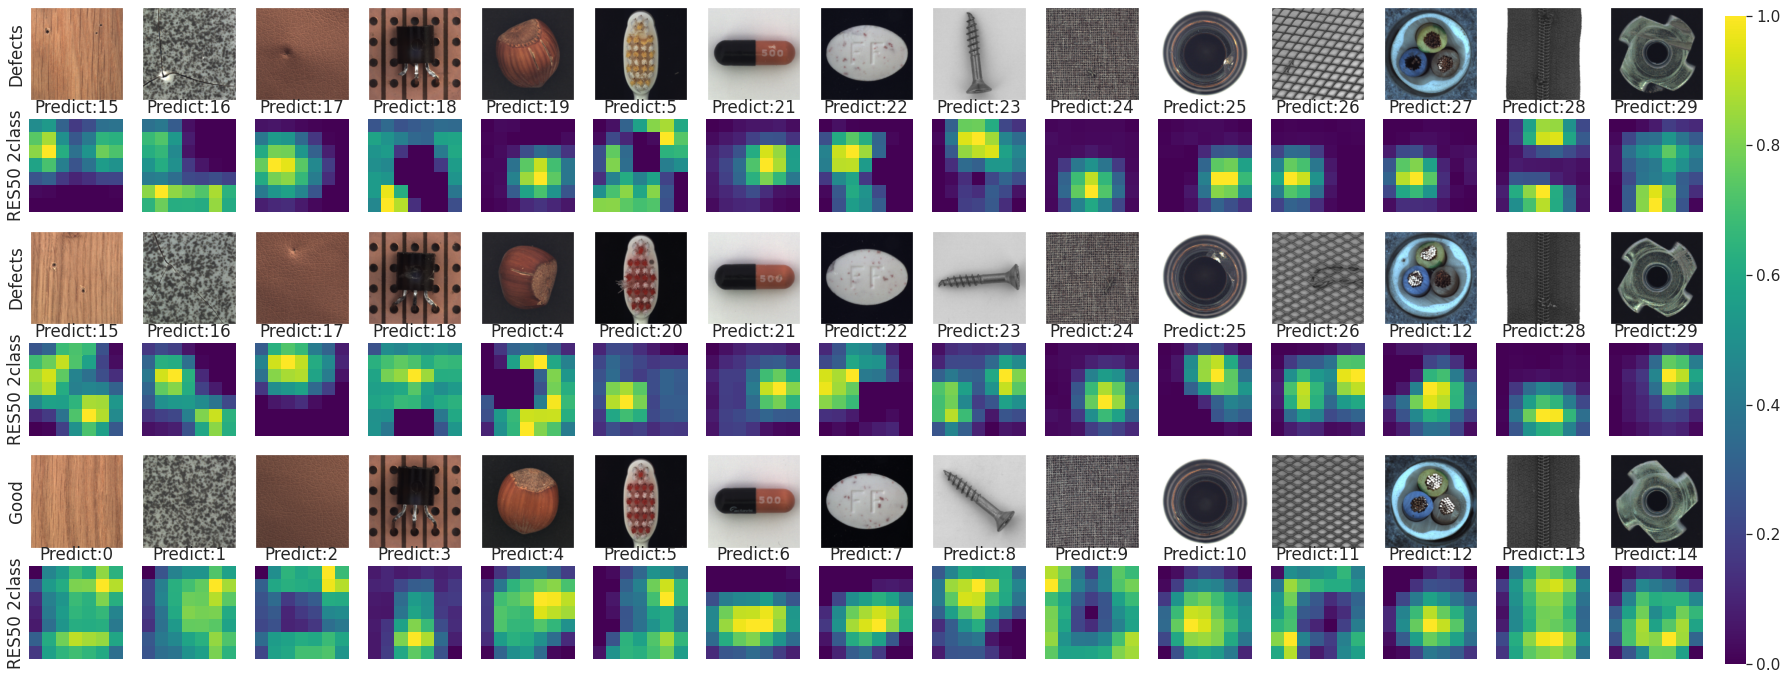

In [18]:
plot_grad(res1,grad_cam,model_name='RES50 2class')

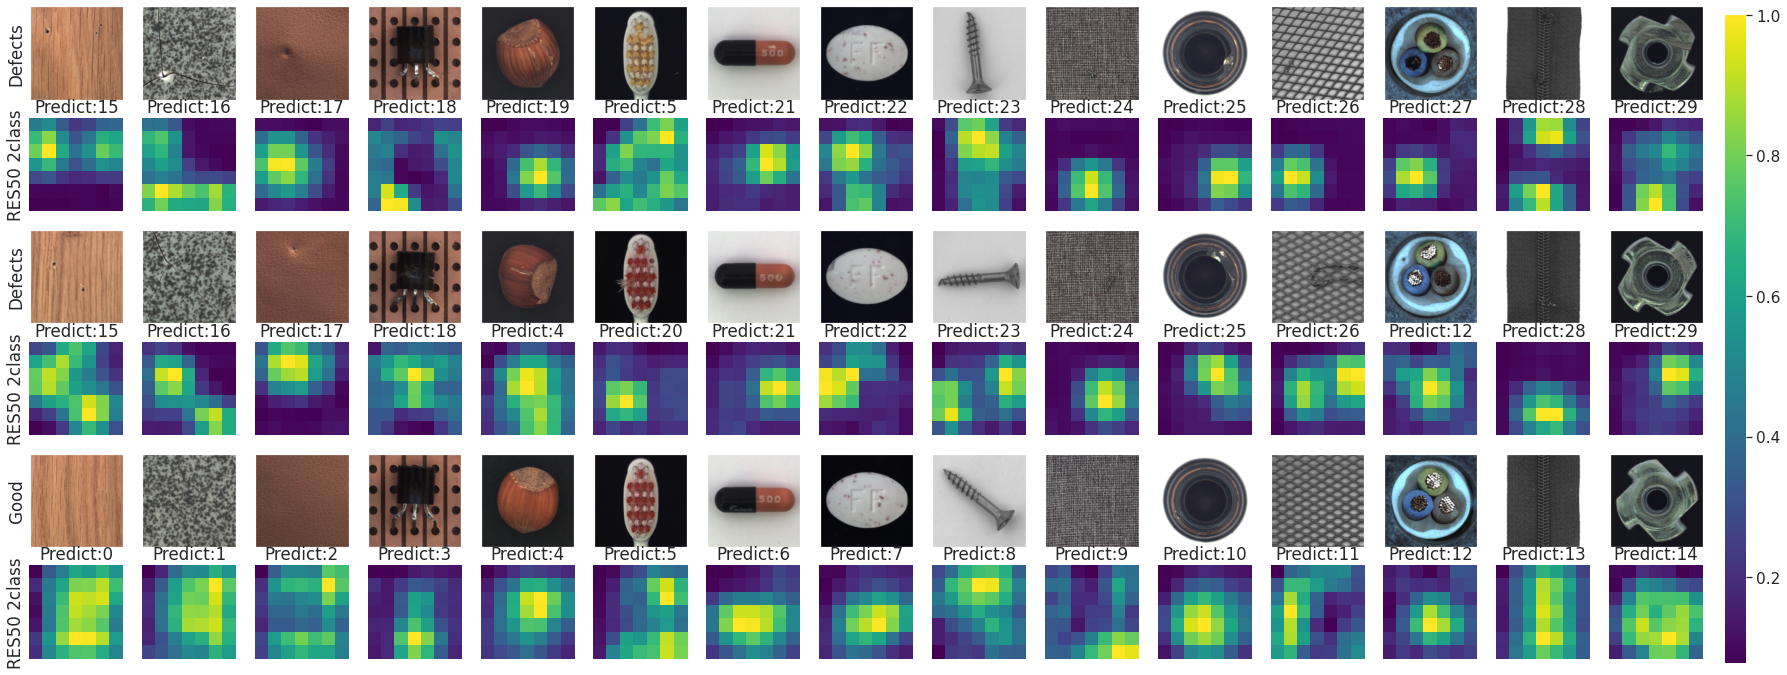

In [19]:
plot_grad(res1,grad_cam_plus,model_name='RES50 2class')